In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision
from PIL import Image
from tqdm.notebook import tqdm
import os
import random
from sklearn.model_selection import train_test_split

In [12]:
def load_image_paths(root_dir):
    original_dir = os.path.join(root_dir, "original")
    degraded_dir = os.path.join(root_dir, "degraded")
    
    original_images = [os.path.join(original_dir, img) for img in os.listdir(original_dir)]
    degraded_images = [os.path.join(degraded_dir, img) for img in os.listdir(degraded_dir)]
    print(degraded_images[:5])
    # Mapping original to degraded
    mapping = {}
    for orig_path in original_images:
        base_name = os.path.basename(orig_path)
        # print(base_name)
        idx, barcode, _ = base_name.split('_')
        # print([img for img in degraded_images])
        degraded_versions = [img for img in degraded_images if img.startswith(f"./data/tmp/degraded/{idx}_{barcode}")]
        mapping[orig_path] = degraded_versions
    
    return mapping

# Assuming '/data/tmp' is your root directory
root_dir = './data/tmp'
image_paths = load_image_paths(root_dir)

# Splitting into train and test sets
original_images = list(image_paths.keys())
train_orig, test_orig = train_test_split(original_images, test_size=0.2, random_state=42)

# Creating train and test mappings
train_mapping = {orig: image_paths[orig] for orig in train_orig}
test_mapping = {orig: image_paths[orig] for orig in test_orig}

['./data/tmp/degraded/1000_7384957649523_ean13_0.png', './data/tmp/degraded/1000_7384957649523_ean13_1.png', './data/tmp/degraded/1000_7384957649523_ean13_10.png', './data/tmp/degraded/1000_7384957649523_ean13_11.png', './data/tmp/degraded/1000_7384957649523_ean13_12.png']


In [13]:
class ImageDataset(Dataset):
    def __init__(self, mapping, transform=None):
        self.mapping = mapping
        self.transform = transform
        self.original_images = list(mapping.keys())
    
    def __len__(self):
        return len(self.original_images)
    
    def __getitem__(self, idx):
        orig_path = self.original_images[idx]
        degraded_paths = self.mapping[orig_path]
        
        # Example: loading the first degraded image
        degraded_path = random.choice(degraded_paths) # Randomly select one for variability
        orig_image = Image.open(orig_path)
        degraded_image = Image.open(degraded_path)
        
        if self.transform:
            orig_image = self.transform(orig_image)
            degraded_image = self.transform(degraded_image)
        
        return degraded_image, orig_image

In [14]:
# Define a function to convert images to binary
def to_binary(tensor, threshold=0.5):
    # Convert to grayscale by averaging the channels
    grayscale = tensor.mean(dim=0, keepdim=True)
    # Apply threshold
    binary = (grayscale > threshold).float()
    return binary

# Create the transform pipeline
transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: to_binary(x))
])

train_dataset = ImageDataset(train_mapping, transform=transform)
test_dataset = ImageDataset(test_mapping, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

torch.Size([1, 1, 256, 512])


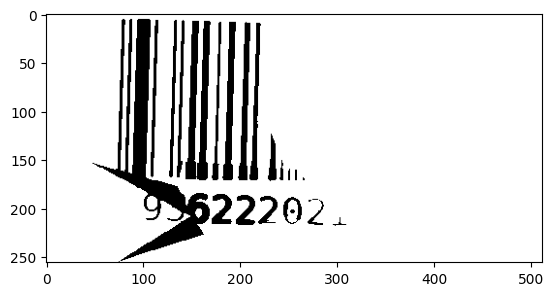

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert a tensor to a numpy array
def imshow(img):
    img = img.numpy() # Convert tensor to numpy array
    plt.imshow(np.transpose(img, (1, 2, 0))) # Convert from CxHxW to HxWxC
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter) # Use next() to get the next batch

# Show images for the first image in the batch
print(images[0].unsqueeze(0).shape)
imshow(torchvision.utils.make_grid(images[0].unsqueeze(0)))

In [16]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
         
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [17]:
model = Autoencoder()

In [18]:
for data in train_loader:
    print(data[0].shape)
    print(data[0][0].shape)
    break

torch.Size([4, 1, 256, 512])
torch.Size([1, 256, 512])


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)
 
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
 
# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    # Wrap train_loader with tqdm for a progress bar
    loop = tqdm(train_loader, leave=True)
    for degraded_images, original_images in loop:
        # Move tensors to the device
        degraded_images = degraded_images.to(device)
        original_images = original_images.to(device)
        
        # Forward pass
        reconstructed_images = model(degraded_images)
        
        # Calculate loss
        loss = criterion(reconstructed_images, original_images)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update progress bar
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

# Save the model
torch.save(model.state_dict(), 'model.pth')

cpu


  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 